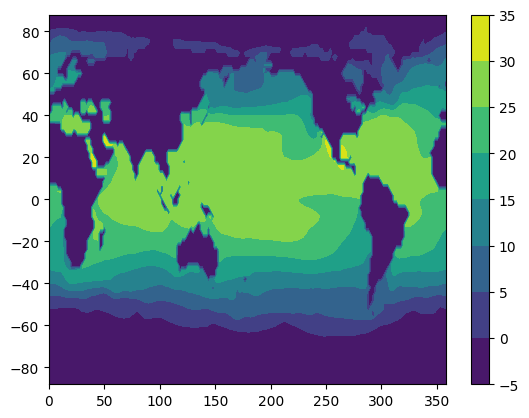

海平面温度数据大小:(180, 89, 1994),数据类型:float64,温度范围:[-1.7999999523162842,34.119998931884766]摄氏度


In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
def temperature_loader(filepath):  
    # 读取包含多个变量的 .mat 文件
    # filepath = 'sea_surface_temperature.mat'
    mat_data = scipy.io.loadmat(filepath)
    
    # 获取变量
    mask = 1 - 1.0*mat_data['seamask']
    sst = mat_data['sst']*np.expand_dims(mask,axis = -1)
    timebnds = mat_data['time_bnds']
    latitude = mat_data['lat']
    longitude = mat_data['lon']
    return mask,sst,timebnds,latitude,longitude
def plot_fig(latitude,longitude,var_numpy):
    lat,lon = np.meshgrid(latitude,longitude)
    plt.contourf(lon.T, lat.T, var1_numpy.T, cmap='viridis')  # cmap参数指定了颜色映射
    plt.colorbar()
    plt.show()
    



mask,sst,timebnds,latitude,longitude = temperature_loader('sea_surface_temperature.mat')
var1_numpy = np.array(sst[:,:,451], dtype=np.float32)
plot_fig(latitude,longitude,var1_numpy)

#这里需要做的假设是,测试温度并没有大波动
min_val = np.min(sst)
max_val = np.max(sst)

print(f"海平面温度数据大小:{sst.shape},数据类型:{sst.dtype},温度范围:[{min_val},{max_val}]摄氏度")
sst = (sst - min_val) / (max_val - min_val)

In [ ]:
# import sys
# import torch
# sys.path.append("ConvLSTM_pytorch-master")
# from convlstm import ConvLSTM
# x = torch.rand((32, 10, 64, 128, 128))   #相当于用前10步64通道的推导出了下一步16通道的张量;32是batchsize
# csm = ConvLSTM(64, 16, 3, 1, True, True, False)
# # _, last_states = csm(x)
# # h = last_states  # 0 for layer index, 0 for h index
# # print(h[0][0].shape)


# csm = ConvLSTM(1, 1, 3, 1, True, True, False)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import sys
from tqdm import tqdm
sys.path.append("ConvLSTM_pytorch-master")
from convlstm import ConvLSTM
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# 假设您有1993个张量，每个张量为180x89
sequence_length = 24
num_samples = 1993
input_shape = (180, 89)
batch_size = 32
# 创建示例数据
sst = torch.Tensor(sst)   # 海平面温度数据
mask = torch.Tensor(mask)  # 陆地0,海洋1掩码
# print(mask.shape)
# 划分训练集和测试集
train_size = int(0.9 * num_samples)
test_size = num_samples - train_size

csm = ConvLSTM(1, 1, 3, 1, device, True, True, False) # 3是卷积核大小
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# csm = csm.to_device(device)
# train_batch = sst[:,:,0:batch_size]

cuda:0


In [3]:
# # # 形成训练输入和对应标签
idx = np.arange(sequence_length,train_size,1)
np.random.shuffle(idx)
batch_size = 16
train_list = []
for k in range(int(idx.shape[0]/batch_size)):
    train_list.append(idx[k*batch_size:(k+1)*batch_size])
train_list.append(idx[(int(idx.shape[0]/batch_size))*batch_size:(int(idx.shape[0]/batch_size)+1)*batch_size])


# # # # 训练过程:
criterion = nn.MSELoss()

# 优化器的参数
learning_rate = 0.001
weight_decay = 0.0001

optimizer = optim.RMSprop(csm.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# # # # 掩码广播辅助变量:
mask_input = mask.unsqueeze(0).unsqueeze(1).unsqueeze(2)
mask_output = mask.unsqueeze(0).unsqueeze(1)

mask_input = mask_input.to(device)
mask_output = mask_output.to(device)
sst = sst.to(device)


num_epochs = 30
sst_tmp = sst[:,:,train_size-sequence_length:].clone()

# sst_tmp = sst_tmp.to(device)

lab = sst[:,:,train_size-sequence_length:].clone()



for epoch in tqdm(range(num_epochs),desc='Epoch'):
    train_Loss = []
    batch_num = 1
    optimizer.zero_grad()
    for batch_idx in train_list:
        sequences = []
        labels = []
        for index in batch_idx:
            # print(index,end = ',')
            sequence = sst[:,:,index-sequence_length:index]
            label = sst[:,:,index]
            sequences.append(sequence)  # 在通道维度上增加一个维度
            labels.append(label)
        # 形成最终的 PyTorch 张量
        final_batch = torch.stack(sequences, dim=0).unsqueeze(2).permute(0,4,2,1,3)
        final_label = torch.stack(labels, dim=0).unsqueeze(1)
        _,inference = csm(final_batch * mask_input)
        loss = criterion(inference[0][0] * mask_output, final_label * mask_output)  # 仅考虑有掩码的部分
        train_Loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(csm.parameters(), 5.0)
        optimizer.step()
        scheduler.step()
        # print('Epoch = {:d}/{:d},batch = {:d}/{:d},loss = {:.4f}'.format(epoch+1,num_epochs,batch_num,len(train_list),loss.item()))
        batch_num = batch_num + 1
    # # 测试集表现:
    train_Loss = np.mean(np.asarray(train_Loss))
    with torch.no_grad():
        for k in range(test_size):
            # print(k:sequence_length+k)
            _,inference = csm(sst_tmp[:,:,k:sequence_length+k].permute(2,0,1).unsqueeze(0).unsqueeze(2) * mask_input)
            sst_tmp[:,:,sequence_length+k] = inference[0][0].squeeze(0).squeeze(0)
            # if (k+1) % 10 == 0:
            #     print("rendering inferences in test set:{:d}/{:d}".format(k+1,test_size))
        loss = criterion((sst_tmp[:,:,sequence_length:]*mask_output.squeeze(0).permute(1,2,0)),\
                    (lab[:,:,sequence_length:]*mask_output.squeeze(0).permute(1,2,0)))
        print('Epoch = {:d}/{:d},train_loss = {:.4f},test_loss = {:.4f}'.format(epoch+1,num_epochs,train_Loss,loss.item()))
        torch.cuda.empty_cache()

Epoch:   3%|██▌                                                                         | 1/30 [00:14<07:14, 14.99s/it]

Epoch = 1/30,train_loss = 0.0108,test_loss = 0.0519


Epoch:   7%|█████                                                                       | 2/30 [00:29<06:50, 14.65s/it]

Epoch = 2/30,train_loss = 0.0037,test_loss = 0.0481


Epoch:  10%|███████▌                                                                    | 3/30 [00:43<06:31, 14.50s/it]

Epoch = 3/30,train_loss = 0.0034,test_loss = 0.0591


Epoch:  13%|██████████▏                                                                 | 4/30 [00:58<06:15, 14.45s/it]

Epoch = 4/30,train_loss = 0.0031,test_loss = 0.0916


Epoch:  17%|████████████▋                                                               | 5/30 [01:12<06:00, 14.43s/it]

Epoch = 5/30,train_loss = 0.0027,test_loss = 0.0374


Epoch:  20%|███████████████▏                                                            | 6/30 [01:26<05:45, 14.41s/it]

Epoch = 6/30,train_loss = 0.0024,test_loss = 0.0400


Epoch:  23%|█████████████████▋                                                          | 7/30 [01:41<05:31, 14.41s/it]

Epoch = 7/30,train_loss = 0.0021,test_loss = 0.0316


Epoch:  27%|████████████████████▎                                                       | 8/30 [01:55<05:16, 14.41s/it]

Epoch = 8/30,train_loss = 0.0019,test_loss = 0.1842


Epoch:  30%|██████████████████████▊                                                     | 9/30 [02:10<05:02, 14.41s/it]

Epoch = 9/30,train_loss = 0.0022,test_loss = 0.0660


Epoch:  33%|█████████████████████████                                                  | 10/30 [02:24<04:47, 14.40s/it]

Epoch = 10/30,train_loss = 0.0013,test_loss = 0.0326


Epoch:  37%|███████████████████████████▍                                               | 11/30 [02:38<04:33, 14.42s/it]

Epoch = 11/30,train_loss = 0.0010,test_loss = 0.0784


Epoch:  40%|██████████████████████████████                                             | 12/30 [02:53<04:19, 14.40s/it]

Epoch = 12/30,train_loss = 0.0011,test_loss = 0.1907


Epoch:  43%|████████████████████████████████▌                                          | 13/30 [03:07<04:04, 14.40s/it]

Epoch = 13/30,train_loss = 0.0011,test_loss = 0.0455


Epoch:  47%|███████████████████████████████████                                        | 14/30 [03:22<03:50, 14.38s/it]

Epoch = 14/30,train_loss = 0.0006,test_loss = 0.0241


Epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [03:36<03:35, 14.40s/it]

Epoch = 15/30,train_loss = 0.0005,test_loss = 0.0315


Epoch:  53%|████████████████████████████████████████                                   | 16/30 [03:50<03:21, 14.40s/it]

Epoch = 16/30,train_loss = 0.0009,test_loss = 0.1644


Epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [04:05<03:07, 14.40s/it]

Epoch = 17/30,train_loss = 0.0008,test_loss = 0.0633


Epoch:  60%|█████████████████████████████████████████████                              | 18/30 [04:19<02:52, 14.40s/it]

Epoch = 18/30,train_loss = 0.0005,test_loss = 0.0280


Epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [04:34<02:38, 14.40s/it]

Epoch = 19/30,train_loss = 0.0006,test_loss = 0.1823


Epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [04:48<02:24, 14.41s/it]

Epoch = 20/30,train_loss = 0.0009,test_loss = 0.1429


Epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [05:03<02:09, 14.44s/it]

Epoch = 21/30,train_loss = 0.0005,test_loss = 0.1550


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [05:17<01:55, 14.43s/it]

Epoch = 22/30,train_loss = 0.0005,test_loss = 0.0878


Epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [05:31<01:40, 14.42s/it]

Epoch = 23/30,train_loss = 0.0008,test_loss = 0.1866


Epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [05:46<01:26, 14.40s/it]

Epoch = 24/30,train_loss = 0.0006,test_loss = 0.1030


Epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [06:00<01:11, 14.40s/it]

Epoch = 25/30,train_loss = 0.0006,test_loss = 0.1504


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [06:14<00:57, 14.40s/it]

Epoch = 26/30,train_loss = 0.0005,test_loss = 0.0586


Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [06:29<00:43, 14.40s/it]

Epoch = 27/30,train_loss = 0.0006,test_loss = 0.1700


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [06:43<00:28, 14.40s/it]

Epoch = 28/30,train_loss = 0.0005,test_loss = 0.0873


Epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [06:58<00:14, 14.39s/it]

Epoch = 29/30,train_loss = 0.0006,test_loss = 0.1491


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [07:12<00:00, 14.42s/it]

Epoch = 30/30,train_loss = 0.0005,test_loss = 0.0463


预测的MSE = 0.9964


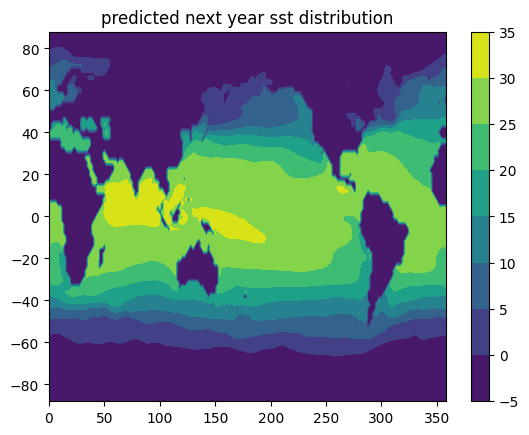

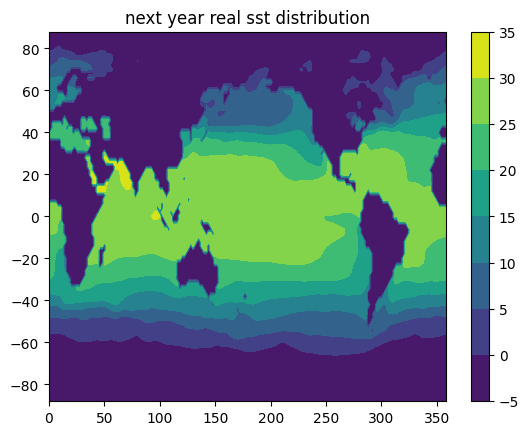

In [4]:
knum = 0

# 把预测和标签归一化到原来区间
pred_image = mask.numpy()*sst_tmp[:,:,sequence_length+knum].detach().cpu().numpy()*(max_val - min_val) + min_val
label_image = mask.numpy()*sst[:,:,train_size+knum].detach().cpu().numpy()*(max_val - min_val) + min_val
print("预测的MSE = {:.4f}".format(np.sum((pred_image - label_image)**2 / pred_image.shape[0] / pred_image.shape[1] )))
lat,lon = np.meshgrid(latitude,longitude)
plt.contourf(lon.T, lat.T, pred_image.T, cmap='viridis')  # cmap参数指定了颜色映射
plt.colorbar()
plt.title('predicted next year sst distribution')
plt.show()

plt.contourf(lon.T, lat.T, label_image.T, cmap='viridis')  # cmap参数指定了颜色映射
plt.colorbar()
plt.title('next year real sst distribution')
plt.show()